# Talking Motion Signature of Individuals
*Ivan Samarskyi, FIT CTU in Prague, Ceneter for Machine Perception, 2024*

---

#### Description
The following notebook analyzes the extracte data from the videoclips, visualises it, and mainly - constructs multi-class SVM classifiers in attempt to find a model that would distinguish individual between each others.

The dataset used in this particular implementstion encompasses *... minutes* of pristine videos of *...* individuals, rendomly taken from VoxCeleb_v2. The videos are processed *as given*, without any additional preprocessing. Each video is splitted into (10 or less)/(5 or less)/(3 or less) seconds clips with 5/2.5/1.5 seconds overlaps respectively. **TODO: (!!!) check how long are the videos which are created, make sure that the overlap makes sense, moreover, most of the videos the algorithm is trained on are 4-10 seconds long(?)**. After that, each clip is being processed in frame-by-frame manner, where from every frame body landmarks, AUs, and head rotations are extracted. **TODO: (!!!) write my own librrary/toolbox to make it as simple and as effective as possible, try to add facial landmarks there, why pytorch/tensorflow conflic with each other**. Consequently, *body_landmarks* are normalized using custom normalising technique **TODO: (!!!) check the technique or build my own.** In order to capture the temporal features, mainly movements of an individual, *temporal correlations* over the whole video clips are used. **TODO: (!!!) take a look at the correlations, why correlations, try something your own.**


### **TODO: (!!!) remove it and put into code, where it will be a part of a dataframe.**
**Example:**
`id01026_xGwXIrtXn7w_00098_c00001`:
- `id01026` id of an individual
- `xGwXIrtXn7w` video id
- `00098` person's occurence
- `c00001` where 00001 is an id of a clip

In [46]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [47]:
CORRELATIONS = ""
EXAMPLE_EXTRACTED = ""
CORRELATIONS = "data/correlations.csv"
EXAMPLE_EXTRACTED = "data/extracted/id01026_z_JRShoMw3k_00104_c0_features.csv" # Remove after the next extraction
# EXAMPLE_EXTRACTED = "data/extracted/id01026_z_JRShoMw3k_00104_c00000.csv" # Uncomment after the next extraction

cors = pd.read_csv(CORRELATIONS, index_col="clip_name")
print("The cor dataset was loaded successfully")

extracted_ex = pd.read_csv(EXAMPLE_EXTRACTED)
print("Example extracted features loaded successfully.")

The cor dataset was loaded successfully
Example extracted features loaded successfully.


An example of how extracted data of a single clip look like and what they exactly mean is presented and discussed below.

In [34]:
display(extracted_ex.info())
display(extracted_ex.nunique())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300 entries, 0 to 299
Data columns (total 31 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Pitch               300 non-null    float64
 1   Roll                300 non-null    float64
 2   Yaw                 300 non-null    float64
 3   Eye Aspect Ratio    300 non-null    float64
 4   Mouth Aspect Ratio  300 non-null    float64
 5   Occ_au_1            300 non-null    float64
 6   Occ_au_2            300 non-null    float64
 7   Occ_au_4            300 non-null    float64
 8   Occ_au_7            300 non-null    float64
 9   Occ_au_15           300 non-null    float64
 10  Occ_au_23           300 non-null    float64
 11  Occ_au_24           300 non-null    float64
 12  Occ_au_6            300 non-null    float64
 13  Occ_au_10           300 non-null    float64
 14  Occ_au_12           300 non-null    float64
 15  Occ_au_14           300 non-null    float64
 16  Occ_au_1

None

Pitch                 300
Roll                  300
Yaw                   300
Eye Aspect Ratio      300
Mouth Aspect Ratio    300
Occ_au_1              300
Occ_au_2              300
Occ_au_4              300
Occ_au_7              299
Occ_au_15             300
Occ_au_23             300
Occ_au_24             300
Occ_au_6              300
Occ_au_10             300
Occ_au_12             300
Occ_au_14             300
Occ_au_17             300
leftShoulder_X        300
leftShoulder_Y        300
rightShoulder_X       300
rightShoulder_Y       300
leftElbow_X           300
leftElbow_Y           300
rightElbow_X          300
rightElbow_Y          300
leftWrist_X           300
leftWrist_Y           300
rightWrist_X          300
rightWrist_Y          300
leftEye_X             300
leftEye_Y             300
dtype: int64

The dataframe encompasses the following features:
- **TODO: (!!!) list of the features with detailted description**

Every feature presented has a *numeric* origin.

The following visualization helps to undersatnd how the extracted features explain the movements of an individual.

**TODO: (!!!) Visualize one video with all action units and body landmarks on it**

The `NaN` values could be present in the dataset in rare cases. Due to the fact that correlations are being calculated on the extracted features of each clip, a correlation can be `NaN` only when one of the values it is calculated in is `NaN`. This, iself, can happen when extractor cannot detect a face or a person on the frame. To make the consequences of the fact that a person is not present on some of the frames, if less then **50%** of frames have `NaN`s in them, they are replaced with `mean`. Otherwise, the correlation will be `NaN`.

On the other hand, from a more high-level perspective, when an extractor fails to find a person on the frame, or faces other obstacles in more than **50%** of frames and these errors trickle to over **10%** of the **correlations**, this row is excluded.

In [48]:
DATAPOINTS_CNT = len(X)
FEATURES_CNT = len(X.columns)
CELLS_CNT = DATAPOINTS_CNT * FEATURES_CNT
NAN_THRESHOLD_P = 0.01
NAN_THRESHOLD_V = NAN_THRESHOLD_P * FEATURES_CNT

# cors.isnull() Return a bitmap for all cells (True/False)
nan_total_ratio = cors.isnull().sum().sum() / CELLS_CNT
print(f"Ratio of NaN values to in the dataset: {nan_total_ratio:.2%}")

nan_row_ratio = cors.isnull().any(axis=1).sum() / DATAPOINTS_CNT
print(f"Ratio of datapoints which have NaN values in them: {nan_row_ratio:.2%}")

nan_row_ratio = (cors.isnull().sum(axis=1) > NAN_THRESHOLD_V).sum() / DATAPOINTS_CNT
print(f"Ratio of datapoints which have more than {NAN_THRESHOLD_P:.2%} NaN values in them: {nan_row_ratio:.2%}, \
[actual NaN features cnt thresh.: {NAN_THRESHOLD_V:.0f}]")

nan_col_ratio = cors.isnull().any().sum() / FEATURES_CNT
print(f"Ratio of features which have NaN values in them: {nan_col_ratio:.2%}")

cors = cors[cors.isna().sum(axis=1) <= NAN_THRESHOLD_V]
print(f"Datapoints left: {len(cors)}, number of NaNs in the dataset: {cors.isnull().sum().sum()}")

Ratio of NaN values to in the dataset: 0.00%
Ratio of datapoints which have NaN values in them: 0.00%
Ratio of datapoints which have more than 1.00% NaN values in them: 0.00%, [actual NaN features cnt thresh.: 5]
Ratio of features which have NaN values in them: 0.00%
Datapoints left: 1, number of NaNs in the dataset: 0


In [51]:
### Remove in the new target session and put this information as columns in a dataset

target = []
for row in cors.iterrows():
    clip_name = row[0]
    person_id = clip_name[2:7]
    video_id = clip_name[8:19]
    occurence_id = clip_name[20:25]
    clip_id = clip_name[27:28] ### Remove in a new training session
    # clip_id = clip_name[27:32] ### Uncomment after a new training session
    target.append(person_id)

cors['target'] = target
cors['target'] = cors['target'].astype('category') 

In [52]:
X = cors.drop("target", axis=1) # clip-related feature
y = cors['target']              # target feature

Split data between train/test with almost equivalent internal distribution of climps of personalities. 

In [71]:
X_train = pd.DataFrame(columns=X.columns)
X_test = pd.DataFrame(columns=X.columns)
y_train = pd.Series(dtype='object')
y_test = pd.Series(dtype='object')

# Create a dictionary for storing the indices of each target
target_dict = {}
for value in y.unique():
    target_indices = cors.index[cors['target'] == value].tolist()
    target_dict[value] = target_indices

# Perform the split for each identity
for identity, indices in target_dict.items():
    train_indices, test_indices = train_test_split(
        indices, test_size=0.3, random_state=42
    )
    
    # Add the corresponding rows to the train and test sets
    X_train = pd.concat([X_train, X.loc[train_indices]])
    X_test = pd.concat([X_test, X.loc[test_indices]])
    y_train = pd.concat([y_train, y.loc[train_indices]])
    y_test = pd.concat([y_test, y.loc[test_indices]])

# Results
print(f"X_train: {X_train.shape}, X_test: {X_test.shape}")

ValueError: With n_samples=1, test_size=0.3 and train_size=None, the resulting train set will be empty. Adjust any of the aforementioned parameters.

Standardize the data as it is required by SVM

In [43]:
scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

The following is the function that is used for a generic SVM model training and all necessary metrics and visualisations

In [55]:
def base_model(X_train: np.ndarray, X_test: np.ndarray, y_train: np.ndarray, y_test: np.ndarray,):
    param_grid = {
        'C': [0.01, 0.1, 1, 10, 100],
        'gamma': ['scale', 'auto'],
        'kernel': ['rbf', 'poly']
    }

    # Perform GridSearchCV for hyperparameter tuning
    grid_search = GridSearchCV(SVC(decision_function_shape='ovv'), param_grid, cv=5, scoring='accuracy', n_jobs=-1)
    grid_search.fit(X_train, y_train)

    print("Best parameters:", grid_search.best_params_)
    print("Best accuracy from GridSearch:", grid_search.best_score_)

    # Train the best SVM on the full training set
    best_svm = grid_search.best_estimator_
    best_svm.fit(X_train, y_train)

    # Make predictions
    y_pred = best_svm.predict(X_test)
    
    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    print("Confusion matrix")
    print(cm)

    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, target_names=[str(label) for label in np.unique(y)]))

Train the full model on the regular data.

In [ ]:
base(X_train, X_test, y_train y_test)

#### Simple visualization

/home/samarrik/projects/protecting_zelenskyi/venv_zel/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


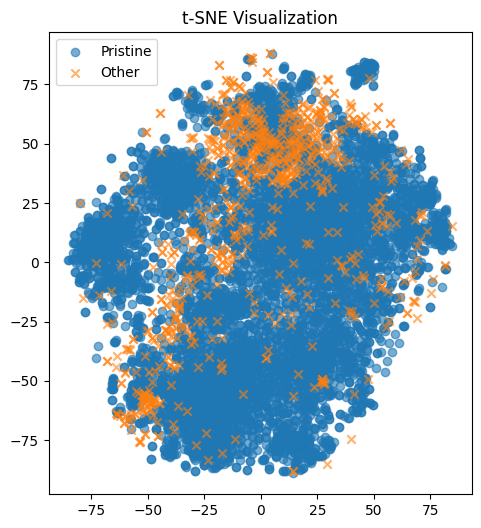

In [60]:
pca = PCA(n_components=50)  # Increased to 50 components
X_pca = pca.fit_transform(X_train)

# Apply t-SNE
tsne = TSNE(
    n_components=2,
    n_iter=3000,          # Increased iterations
    perplexity=40,        # Adjusted perplexity
    learning_rate=200,    # Adjusted learning rate
    random_state=42
)
X_tsne = tsne.fit_transform(X_pca)

# Plotting the t-SNE results for multi-class labels
plt.figure(figsize=(10, 8))

# Loop through unique classes in y_train
unique_classes = np.unique(y_train)
for class_label in unique_classes:
    # Filter data for the current class
    class_mask = (y_train == class_label)
    plt.scatter(
        X_tsne[class_mask, 0],
        X_tsne[class_mask, 1],
        label=f"Class {class_label}",
        alpha=0.6,
        edgecolors='w'
    )

plt.title('t-SNE Visualization for Multi-Class Data')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.legend()
plt.show()

In [ ]:
# Subset of features
# Clip length
# Influence of compression
# Split the dataset in 3 (combined/only_facial/only_body)